In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

print("numpy version:", np.__version__)
print("tensorflow version:", tf.__version__)
print("pandas version:", pd.__version__)

numpy version: 1.13.3
tensorflow version: 1.4.0
pandas version: 0.19.2


## Parsing the SkillCraft dataset from CSV

The first step is to get the data into a form Python can manipulate. Might be worth converting the data and saving it in .npz format as a one-time operation.

There are 20 attributes in the dataset but the authors really only use fields 6-20. Hence it didn't matter that some rows exist with '?' in one or more attributes which need to be filtered out at least for some learning. Might be interesting to predict their values.

Looking more closely at the data, there exist 3395 records (vs 3305+55 used in paper). This discrepancy is because 35 'Grandmaster' games were dropped and 55 'Professional' games were added. 57 of these records contain at least one missing attribute. These are rows 360, 1843, 3342-3396. However, these attributes "Age", "TotalHours", "HoursPerWeek" were not used in the study.

In [2]:
# with open('SkillCraft1_Dataset.csv', 'rb') as skillcraft:
#     # default delimiter=',' and quotechar='"'
#     reader = csv.DictReader(skillcraft)
#     for row in reader:
#         print(row)

In [3]:
skillcraft = pd.read_csv('SkillCraft1_Dataset.csv')
print(type(skillcraft))

<class 'pandas.core.frame.DataFrame'>


In [4]:
print(pd.unique(skillcraft['LeagueIndex']))
# skillcraft.query('LeagueIndex != 7')

[5 4 3 2 1 7 6 8]


Currently keeping Grandmaster games even though paper (Thompson et al. 2013) discarded them.

In [5]:
data = skillcraft.iloc[:, 5:]
print(type(data))
print(data.shape)
print(data.iloc[3393])

<class 'pandas.core.frame.DataFrame'>
(3395, 15)
APM                     375.866400
SelectByHotkeys           0.036436
AssignToHotkeys           0.000594
UniqueHotkeys             5.000000
MinimapAttacks            0.000204
MinimapRightClicks        0.000780
NumberOfPACs              0.004346
GapBetweenPACs           11.691000
ActionLatency            34.854700
ActionsInPAC              7.961500
TotalMapExplored         15.000000
WorkersMade               0.000613
UniqueUnitsMade           6.000000
ComplexUnitsMade          0.000000
ComplexAbilitiesUsed      0.000631
Name: 3393, dtype: float64


The leagues should be the labels/targets.

In [6]:
target = skillcraft.iloc[:, 1]
print(type(target))
print(target.shape)

<class 'pandas.core.series.Series'>
(3395,)


In [7]:
data = data.values
print(type(data))
print(data.shape)

<type 'numpy.ndarray'>
(3395, 15)


In [8]:
target = target.values
print(type(target))
print(target.shape)

<type 'numpy.ndarray'>
(3395,)


In [9]:
#np.random.seed(45689)
rnd_idx = np.arange(np.shape(data)[0])
np.random.shuffle(rnd_idx)

#trBatch = int(np.ceil(0.8*len(rnd_idx)))
#validBatch = int(np.ceil(0.1*len(rnd_idx)))
trBatch = 3050

trainData, testData = (data[rnd_idx[0:trBatch],:],
                       data[rnd_idx[trBatch:],:])

trainTarget, testTarget = (target[rnd_idx[0:trBatch]],
                           target[rnd_idx[trBatch:]])

In [10]:
print("trainData shape:", trainData.shape)
print("trainTarget shape:", trainTarget.shape)
print("testData shape:", testData.shape)
print("testTarget shape:", testTarget.shape)

trainData shape: (3050, 15)
trainTarget shape: (3050,)
testData shape: (345, 15)
testTarget shape: (345,)


Checking the label distributions.

In [11]:
print(trainData.dtype)
print(trainTarget.dtype)

# decrementing each ordinal value by one in order to one-hot encode each record
trainTarget = trainTarget-1
testTarget = testTarget-1

print(np.unique(trainTarget))
print(np.unique(testTarget))
print(np.bincount(trainTarget))
print(np.bincount(testTarget))

float64
int64
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
[148 318 500 724 720 556  33  51]
[19 29 53 87 86 65  2  4]


In [12]:
# need to expand the targets (currently just a scalar) into a one-hot 10-D vector
# code from https://stackoverflow.com/a/42874726/8346497
classes = np.unique(trainTarget).shape[0]
trainTarget = np.eye(classes)[trainTarget]
testTarget = np.eye(classes)[testTarget]

print("new trainTarget shape:", trainTarget.shape)
print("new testTarget shape:", testTarget.shape)

new trainTarget shape: (3050, 8)
new testTarget shape: (345, 8)


## Experiment 1: Predict Rank/League of Player

This is a classification task, so we could use logistic regression (but the paper says there are "assumptions about the structure of the relationship between the predictive variables and the response") or neural nets.

Using only attributes 6-20, just like the paper.

Let's see how well the neural net can do for 8-way classification.

In [13]:
def build_layer(incoming, num_hidden_units):
    """
    incoming: the input tensor containing the hidden activations from previous layer
    num_hidden_units: the number of hidden units for this layer
    
    takes the hidden activations from the previous layer and then returns the weighted sum of
    the inputs for the current hidden layer (before passing through activation)
        
    also return the weights W_layer for regularization
    """
    # Xavier initialization
    num_input_units = incoming.get_shape().as_list()[1]
    variance = 3. / (num_input_units + num_hidden_units)
    
    W_layer = tf.Variable(tf.truncated_normal(shape=[num_input_units, num_hidden_units], stddev=tf.sqrt(variance)))
    b_layer = tf.Variable(tf.constant(0.0, shape=[num_hidden_units]))
    
    # the output of this hidden layer
    layer = tf.matmul(incoming, W_layer) + b_layer
    return layer, W_layer

In [14]:
def cross_validation(data, target, i, cv_index):
    """
    data:
    target:
    
    Returns two datasets (composed of data and labels) partitioned into size (i-1)*N/i and N/i.
    The split is made along cv_index (should be greater than 1)
    Precondition: i >= 3, 1 <= cv_index <= i-1
    """
    data_cv = np.split(data, i)
    target_cv = np.split(target, i)
    
    trainData = np.concatenate(data_cv[0:cv_index] + data_cv[cv_index+1:], axis=0)
    trainTarget = np.concatenate(target_cv[0:cv_index] + target_cv[cv_index+1:], axis=0)
    
    validData = data_cv[cv_index]
    validTarget = target_cv[cv_index]
    
    return trainData, trainTarget, validData, validTarget

In [15]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer_in, W_layer1 = build_layer(X, 1000)
keep_prob = tf.placeholder(tf.float32) # control dropout to activate during training only
hidden_layer_out = tf.nn.dropout(tf.nn.relu(hidden_layer_in), keep_prob)

# hidden layer to output
y_predicted, W_layer2 = build_layer(hidden_layer_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 3e-4
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2)
cross_entropy += penalty * regularizers

In [16]:
global_step = tf.Variable(0, trainable=False)
eta_0 = 1e-3
eta = tf.train.exponential_decay(eta_0, global_step, 5000, 0.1, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy, global_step=global_step)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))

In [17]:
batch_size=256

train_errors = []
valid_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    
    split = 10
    
    # since there are more training sets, reduce number of iterations of training per set
    for partition in range(0, split):
        trainDataCV, trainTargetCV, validData, validTarget = cross_validation(trainData, trainTarget, split, partition)
        
        for step in range(1, 101):
            if i >= trainDataCV.shape[0]:
                i -= trainDataCV.shape[0]
                train_error, train_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                               y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                               keep_prob: 1.0})
                valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: validData,
                                                               y_target: validTarget,
                                                               keep_prob: 1.0})
                train_xentropy_losses.append(train_loss)
                train_errors.append(train_error)
                valid_xentropy_losses.append(valid_loss)
                valid_errors.append(valid_error)

            indices = range(i, i+batch_size)
            _, loss = sess.run([train, cross_entropy], feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                                  y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                                  keep_prob: 0.5})
            i += batch_size

            if (step % 20 == 0):
                train_error, train_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                               y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                               keep_prob: 1.0})
                valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: validData,
                                                               y_target: validTarget,
                                                               keep_prob: 1.0})
                print("Iter: %4d, xentropy-train: %4.6f, xentropy-valid: %4.6f, Train errs: %d, Valid errs: %d"%
                      (partition*100+step, train_loss, valid_loss, train_error, valid_error))

Iter:   20, xentropy-train: 3.854614, xentropy-valid: 3.283716, Train errs: 183, Valid errs: 195
Iter:   40, xentropy-train: 2.577492, xentropy-valid: 2.308687, Train errs: 160, Valid errs: 180
Iter:   60, xentropy-train: 1.885919, xentropy-valid: 1.797439, Train errs: 163, Valid errs: 178
Iter:   80, xentropy-train: 1.717638, xentropy-valid: 1.664129, Train errs: 157, Valid errs: 180
Iter:  100, xentropy-train: 1.710495, xentropy-valid: 1.692398, Train errs: 169, Valid errs: 182
Iter:  120, xentropy-train: 1.628137, xentropy-valid: 1.456784, Train errs: 157, Valid errs: 182
Iter:  140, xentropy-train: 1.390746, xentropy-valid: 1.392766, Train errs: 151, Valid errs: 184
Iter:  160, xentropy-train: 1.447616, xentropy-valid: 1.381681, Train errs: 151, Valid errs: 183
Iter:  180, xentropy-train: 1.428371, xentropy-valid: 1.366972, Train errs: 166, Valid errs: 182
Iter:  200, xentropy-train: 1.334953, xentropy-valid: 1.368625, Train errs: 144, Valid errs: 180
Iter:  220, xentropy-train: 1.

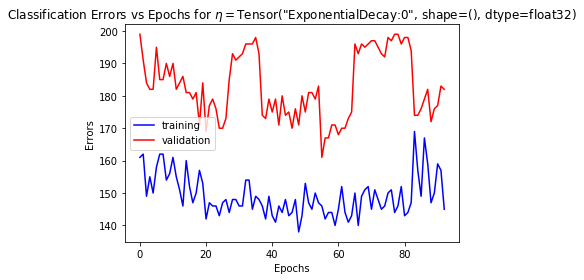

In [18]:
# plot training curve for classification error vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.title('Classification Errors vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

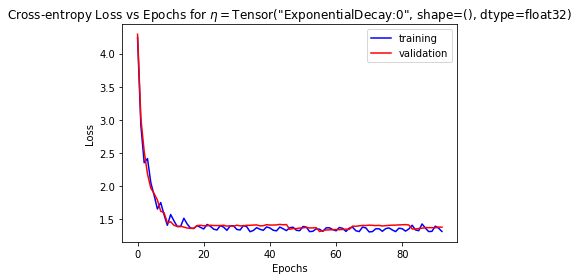

In [19]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.title('Cross-entropy Loss vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [34]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer1_in, W_layer1 = build_layer(X, 500)
keep_prob1 = tf.placeholder(tf.float32) # control dropout to activate during training only
hidden_layer1_out = tf.nn.dropout(tf.nn.relu(hidden_layer1_in), keep_prob1)

# first hidden layer to second hidden layer
hidden_layer2_in, W_layer2 = build_layer(hidden_layer1_out, 500)
keep_prob2 = tf.placeholder(tf.float32)
hidden_layer2_out = tf.nn.dropout(tf.nn.relu(hidden_layer2_in), keep_prob2)

# second hidden layer to output
y_predicted, W_layer3 = build_layer(hidden_layer2_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 3e-4
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2) + tf.nn.l2_loss(W_layer3)
cross_entropy += penalty * regularizers

In [35]:
global_step = tf.Variable(0, trainable=False)
eta_0 = 1e-3
eta = tf.train.exponential_decay(eta_0, global_step, 5000, 0.1, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy, global_step=global_step)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))

In [36]:
batch_size=256

train_errors = []
valid_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    
    split = 10
    
    # since there are more training sets, reduce number of iterations of training per set
    for partition in range(0, split):
        trainDataCV, trainTargetCV, validData, validTarget = cross_validation(trainData, trainTarget, split, partition)
        
        for step in range(1, 201):
            if i >= trainDataCV.shape[0]:
                i -= trainDataCV.shape[0]
                train_error, train_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                               y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                               keep_prob1: 1.0,
                                                               keep_prob2: 1.0})
                valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: validData,
                                                               y_target: validTarget,
                                                               keep_prob1: 1.0,
                                                               keep_prob2: 1.0})
                train_xentropy_losses.append(train_loss)
                train_errors.append(train_error)
                valid_xentropy_losses.append(valid_loss)
                valid_errors.append(valid_error)

            indices = range(i, i+batch_size)
            _, loss = sess.run([train, cross_entropy], feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                                  y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                                  keep_prob1: 0.5,
                                                                  keep_prob2: 0.5})
            i += batch_size

            if (step % 40 == 0):
                train_error, train_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                               y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                               keep_prob1: 1.0,
                                                               keep_prob2: 1.0})
                valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: validData,
                                                               y_target: validTarget,
                                                               keep_prob1: 1.0,
                                                               keep_prob2: 1.0})
                print("Iter: %4d, xentropy-train: %4.6f, xentropy-valid: %4.6f, Train errs: %d, Valid errs: %d"%
                      (partition*200+step, train_loss, valid_loss, train_error, valid_error))

Iter:   40, xentropy-train: 1.851982, xentropy-valid: 1.864678, Train errs: 185, Valid errs: 212
Iter:   80, xentropy-train: 1.686125, xentropy-valid: 1.695683, Train errs: 163, Valid errs: 206
Iter:  120, xentropy-train: 1.585821, xentropy-valid: 1.602812, Train errs: 167, Valid errs: 199
Iter:  160, xentropy-train: 1.534405, xentropy-valid: 1.564575, Train errs: 160, Valid errs: 213
Iter:  200, xentropy-train: 1.506317, xentropy-valid: 1.540138, Train errs: 163, Valid errs: 204
Iter:  240, xentropy-train: 1.449342, xentropy-valid: 1.486901, Train errs: 150, Valid errs: 198
Iter:  280, xentropy-train: 1.502118, xentropy-valid: 1.493123, Train errs: 168, Valid errs: 199
Iter:  320, xentropy-train: 1.468786, xentropy-valid: 1.483972, Train errs: 166, Valid errs: 193
Iter:  360, xentropy-train: 1.502943, xentropy-valid: 1.482122, Train errs: 146, Valid errs: 191
Iter:  400, xentropy-train: 1.480673, xentropy-valid: 1.479273, Train errs: 158, Valid errs: 201
Iter:  440, xentropy-train: 1.

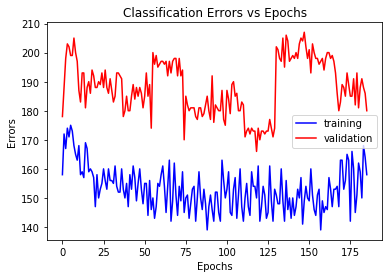

In [25]:
# plot training curve for classification error vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.title('Classification Errors vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

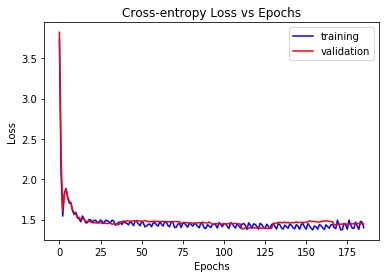

In [26]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.title('Cross-entropy Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Results on test set

In [15]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer_in, W_layer1 = build_layer(X, 500)
keep_prob = tf.placeholder(tf.float32) # control dropout to activate during training only
hidden_layer_out = tf.nn.dropout(tf.nn.relu(hidden_layer_in), keep_prob)

# hidden layer to output
y_predicted, W_layer2 = build_layer(hidden_layer_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 3e-4
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2)
cross_entropy += penalty * regularizers

In [16]:
global_step = tf.Variable(0, trainable=False)
eta_0 = 1e-3
eta = tf.train.exponential_decay(eta_0, global_step, 5000, 0.1, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy, global_step=global_step)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_class_predicted, y_class_target), tf.float32))

In [17]:
batch_size=256

train_accuracies = []
valid_accuracies = []
test_accuracies = []
train_errors = []
valid_errors = []
test_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []
test_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    
    split = 10
    
    # since there are more training sets, reduce number of iterations of training per set
    for partition in range(0, split):
        trainDataCV, trainTargetCV, validData, validTarget = cross_validation(trainData, trainTarget, split, partition)
        
        for step in range(1, 201):
            if i >= trainDataCV.shape[0]:
                i -= trainDataCV.shape[0]
                train_acc, train_error, train_loss = sess.run([accuracy, errors, cross_entropy],
                                                               feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                                          y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                                          keep_prob: 1.0})
                valid_acc, valid_error, valid_loss = sess.run([accuracy, errors, cross_entropy],
                                                               feed_dict={X: validData, y_target: validTarget,
                                                                          keep_prob: 1.0})
                test_acc, test_error, test_loss = sess.run([accuracy, errors, cross_entropy],
                                                            feed_dict={X: testData, y_target: testTarget,
                                                                       keep_prob: 1.0})
                train_xentropy_losses.append(train_loss)
                train_accuracies.append(train_acc)
                train_errors.append(train_error)
                
                valid_xentropy_losses.append(valid_loss)
                valid_accuracies.append(valid_acc)
                valid_errors.append(valid_error)
                
                test_xentropy_losses.append(test_loss)
                test_accuracies.append(test_acc)
                test_errors.append(test_error)

            indices = range(i, i+batch_size)
            _, loss = sess.run([train, cross_entropy], feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                                  y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                                  keep_prob: 0.5})
            i += batch_size

            if (step % 25 == 0):
                train_error, train_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                               y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                               keep_prob: 1.0})
                valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: validData,
                                                               y_target: validTarget,
                                                               keep_prob: 1.0})
                test_error, test_loss = sess.run([errors, cross_entropy],
                                                  feed_dict={X: testData,
                                                             y_target: testTarget,
                                                             keep_prob: 1.0})
                print("Iter: %4d, x-train: %4.5f, x-valid: %4.5f, x-test: %4.5f, Train errs: %d, Valid errs: %d, Test errs: %d"%
                      (partition*200+step, train_loss, valid_loss, test_loss, train_error, valid_error, test_error))

Iter:   25, x-train: 3.76195, x-valid: 3.73327, x-test: 2.96175, Train errs: 169, Valid errs: 207, Test errs: 211
Iter:   50, x-train: 2.17585, x-valid: 2.48019, x-test: 2.15407, Train errs: 156, Valid errs: 200, Test errs: 210
Iter:   75, x-train: 1.88566, x-valid: 2.05144, x-test: 1.72998, Train errs: 151, Valid errs: 206, Test errs: 220
Iter:  100, x-train: 1.69634, x-valid: 1.78224, x-test: 1.54978, Train errs: 164, Valid errs: 209, Test errs: 218
Iter:  125, x-train: 1.38290, x-valid: 1.57278, x-test: 1.44552, Train errs: 142, Valid errs: 202, Test errs: 212
Iter:  150, x-train: 1.47305, x-valid: 1.57790, x-test: 1.44765, Train errs: 146, Valid errs: 198, Test errs: 214
Iter:  175, x-train: 1.50154, x-valid: 1.50945, x-test: 1.41476, Train errs: 158, Valid errs: 200, Test errs: 208
Iter:  200, x-train: 1.37926, x-valid: 1.49136, x-test: 1.39653, Train errs: 148, Valid errs: 193, Test errs: 205
Iter:  225, x-train: 1.41701, x-valid: 1.38997, x-test: 1.38663, Train errs: 144, Valid 

Iter: 1925, x-train: 1.36728, x-valid: 1.39259, x-test: 1.37926, Train errs: 143, Valid errs: 176, Test errs: 196
Iter: 1950, x-train: 1.34946, x-valid: 1.39259, x-test: 1.37509, Train errs: 155, Valid errs: 171, Test errs: 202
Iter: 1975, x-train: 1.33755, x-valid: 1.40809, x-test: 1.37915, Train errs: 145, Valid errs: 178, Test errs: 200
Iter: 2000, x-train: 1.38275, x-valid: 1.40002, x-test: 1.37902, Train errs: 153, Valid errs: 173, Test errs: 199


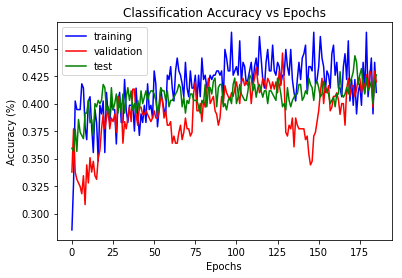

In [18]:
# plot training curve for classification accuracy vs number of epochs
plt.plot(train_accuracies, 'b-', label='training')
plt.plot(valid_accuracies, 'r-', label='validation')
plt.plot(test_accuracies, 'g-', label='test')
plt.title('Classification Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

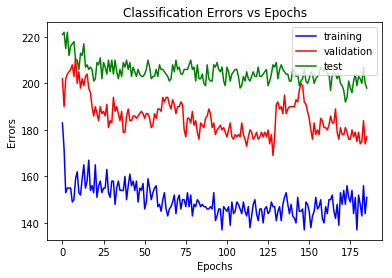

In [19]:
# plot training curve for classification error vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.plot(test_errors, 'g-', label='test')
plt.title('Classification Errors vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

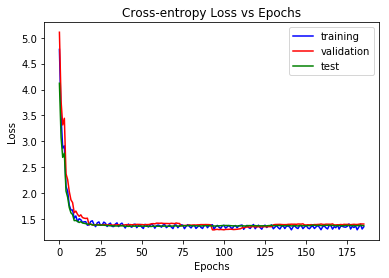

In [20]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.plot(test_xentropy_losses, 'g-', label='test')
plt.title('Cross-entropy Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()